In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

/home/kopita/anaconda3/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Bajar el dataset de imágenes

Download http://download.tensorflow.org/example_images/flower_photos.tgz

> tar -xvzf flower_photos.tgz

# Cargando las imagenes

Vamos a usar la clase [ImageDataGenerator](https://keras.io/preprocessing/image/) de keras para cargar las imagenes, esta clase nos ayuda a cargar las imagenes en batch, a aplicarles una función de preprocesamiento y aplicar data augmentation.

In [16]:
path = '/home/kopita/datasets/flower_photos/'
img_size = 224
batch_size = 64

In [10]:
# Especificamos la función de preprocesamiento
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Usamos la función "flow_from_directory" para cargar las imagenes desde un folder.

La estructura de la carpeta que espera la función es importante. Cada clase de nuestro dataset tiene que estar dentro de una carpeta con el nombre de la clase:

* path:
  - class1
    - img1, img2, img3, ...
  - class2
    - img1, img2, img3, ...
  - class3
    - img1, img2, img3, ...

Es una estructura común en los datasets de imágenes.

In [17]:
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size)

Found 3670 images belonging to 5 classes.


In [18]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [29]:
# Si querems El parámetro filenames, guarda la ruta de las imágenes
train_generator.filenames[:3]

['daisy/100080576_f52e8ee070_n.jpg',
 'daisy/10140303196_b88d3d6cec.jpg',
 'daisy/10172379554_b296050f82_n.jpg']

roses/2258973326_03c0145f15_n.jpg


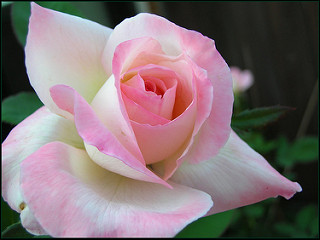

In [35]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + random_img)

In [36]:
# Veamos como se extrae un batch del generator
batch_x, batch_y = train_generator.next()
batch_x.shape, batch_y.shape

((64, 224, 224, 3), (64, 5))

# Cargar una red entrenada

Vamos a cargar la red **ResNet50** ya entrenada, pero sin incluir las capas densas, ya que vamos a adaptar la red a nuestro caso específico.

In [47]:
model = ResNet50(include_top=False, input_shape=(img_size,img_size,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [48]:
model.input, model.output

(<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'avg_pool_1/AvgPool:0' shape=(?, 1, 1, 2048) dtype=float32>)

In [49]:
%%time
output = model.predict_on_batch(batch_x)
output.shape

CPU times: user 50 s, sys: 4.84 s, total: 54.9 s
Wall time: 1min 34s


In [ ]:
print('%.2f minutos por epoch.' % ((train_generator.samples // batch_size) * elapsed / 60))

# Precompute

In [ ]:
n_batch = train_generator.samples // batch_size
n_batch

In [ ]:
train_generator.reset()
outputs_x = []
outputs_y = []

for i in range(n_batch):
    print('%d/%d...' % (i+1, n_batch), end='\r')
    batch_x, batch_y = train_generator.next()
    outputs_x.append(model.predict_on_batch(batch_x))
    outputs_y.append(batch_y)

In [ ]:
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

In [ ]:
# Redimensionando
outputs_x = outputs_x[:,0,0,:]
outputs_x.shape, outputs_y.shape

In [ ]:
outputs_x[0], outputs_y[0]

In [ ]:
# # Guardar arrays
# np.savez_compressed('3-outputs', x=outputs_x, y=outputs_y)

In [ ]:
# Cargar arrays
outputs_x = np.load('3-outputs.npz')['x']
outputs_y = np.load('3-outputs.npz')['y']

In [ ]:
outputs_x.shape, outputs_y.shape

# Entrenar a partir de los features extraidos

In [ ]:
flowers_model = Sequential()
flowers_model.add(Dense(128, activation='relu', input_shape=(2048,)))
flowers_model.add(Dense(5, activation='softmax'))
flowers_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
flowers_model.summary()

In [ ]:
log = flowers_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

In [ ]:
plt.plot(log.history['loss'], '-o');

# Definiendo el modelo completo

In [ ]:
base_model = ResNet50(include_top=False)

In [ ]:
final_model = Sequential()
final_model.add(base_model)
final_model.add(flowers_model)
final_model.summary()

# Usando el modelo

In [ ]:
random_img = np.random.choice(train_generator.filenames)
print(random_img)
img = Image.open(path + random_img)
img

In [ ]:
# TODO:
# resize img
# pasar a formato de array
# redimensionar
# preprocesar

In [ ]:
# Obtener prediccion

In [ ]:
# Se crea un diccionario de indice a clase
index2class = {train_generator.class_indices[k]:k for k in train_generator.class_indices}
index2class

In [ ]:
# Usando el diccionario y la funcion np.argmax, obtener el nombre de la clase predecida
index2class[np.argmax()]

# Resumiendo en una funcion

In [ ]:
def get_class(path):
    # TODO
    return pred

In [ ]:
get_class(np.random.choice(train_generator.filenames))